In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Matrix Capsules with EM Routing
This notebook covers the fundamental components introduced in this paper. The routing procedure is covered from the bottom up. This will serve as a starting point to implementing the complete solution.

In [20]:
def cost_function(beta_u, sigma_j, R_j):
    """Computes the cost of the h-th dimension."""
    return (beta_u + torch.log(sigma_j)) * R_j.sum()

def activation(lam, beta_a, cost):
    """Activation function for a capsule j."""
    return torch.sigmoid(lam * (beta_a - cost.sum()))

## Activation Function
What does the activation function look like? Under what circumstances is a capsule activated?

In [33]:
cost = torch.Tensor(np.linspace(-1, 1, 21))
beta_a = 0.5
lam = 1
r = []
for i in range(cost.shape[0]):
    r.append(activation(lam, beta_a, cost[i]))

<IPython.core.display.Javascript object>


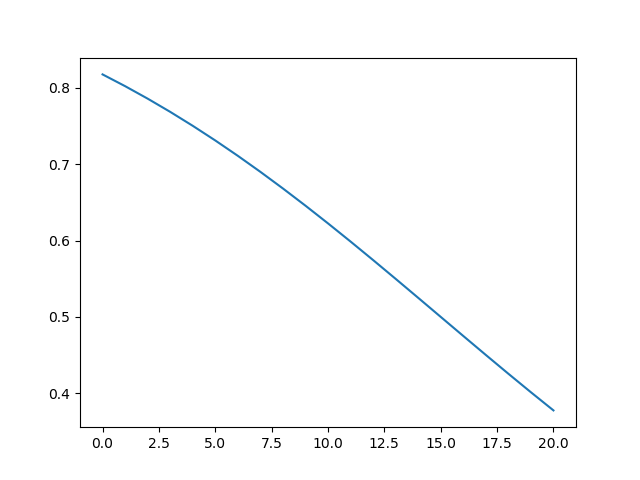

In [34]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(r)